In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# 数据预处理和数据增强
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 加载数据集
dataset_path = './ColorectalCancer'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# 数据集划分为训练集和验证集
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
import torch.nn as nn
from torchvision import models

# 定义 ResNet-18 模型，并移除最后的全连接层
class CustomResNet18(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomResNet18, self).__init__()
        resnet = models.resnet18(pretrained=False)  # 不使用预训练权重
        self.features = nn.Sequential(*list(resnet.children())[:-1])  # 移除最后的分类层
        self.classifier = nn.Linear(resnet.fc.in_features, num_classes)  # 新的分类层

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # 展平
        x = self.classifier(x)
        return x

model = CustomResNet18(num_classes=3).to(device)


c:\Users\zhzjh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\zhzjh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
import torch.optim as optim

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 训练模型
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # 前向传播
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_loss /= train_total

    # 验证模型
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_loss /= val_total

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")


Epoch [1/10], Train Loss: 0.6785, Train Acc: 71.79%, Val Loss: 1.1903, Val Acc: 60.92%
Epoch [2/10], Train Loss: 0.4504, Train Acc: 82.29%, Val Loss: 0.4229, Val Acc: 83.33%
Epoch [3/10], Train Loss: 0.3500, Train Acc: 86.67%, Val Loss: 0.9085, Val Acc: 66.17%
Epoch [4/10], Train Loss: 0.3199, Train Acc: 87.90%, Val Loss: 0.4308, Val Acc: 84.92%
Epoch [5/10], Train Loss: 0.3037, Train Acc: 88.58%, Val Loss: 0.9697, Val Acc: 64.67%
Epoch [6/10], Train Loss: 0.2414, Train Acc: 91.35%, Val Loss: 0.2674, Val Acc: 89.75%
Epoch [7/10], Train Loss: 0.2165, Train Acc: 91.29%, Val Loss: 0.1602, Val Acc: 94.50%
Epoch [8/10], Train Loss: 0.2104, Train Acc: 92.21%, Val Loss: 0.7845, Val Acc: 79.50%
Epoch [9/10], Train Loss: 0.1915, Train Acc: 92.90%, Val Loss: 0.5651, Val Acc: 81.92%
Epoch [10/10], Train Loss: 0.1776, Train Acc: 93.60%, Val Loss: 0.1245, Val Acc: 95.08%


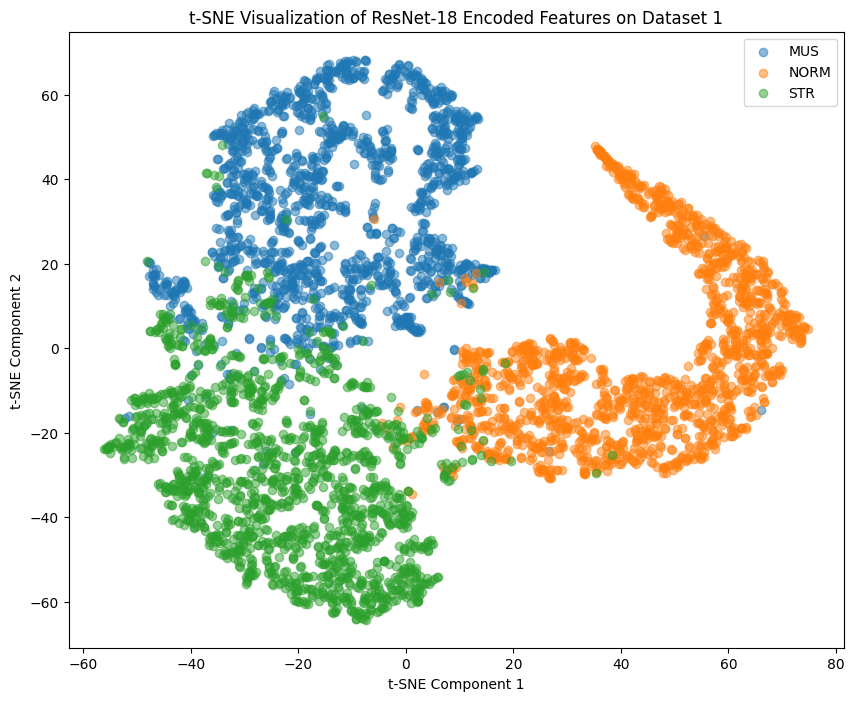

In [5]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# 特征提取函数
def extract_features(data_loader, model):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for images, label in data_loader:
            images = images.to(device)
            output = model.features(images)
            features.append(output.view(output.size(0), -1).cpu().numpy())
            labels.append(label.numpy())
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels

# 提取训练集的特征
train_features, train_labels = extract_features(train_loader, model)

# 使用 t-SNE 进行降维
tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(train_features)

# 可视化 t-SNE 结果
plt.figure(figsize=(10, 8))
for label in np.unique(train_labels):
    idx = train_labels == label
    plt.scatter(reduced_features[idx, 0], reduced_features[idx, 1], label=dataset.classes[label], alpha=0.5)
plt.legend()
plt.title("t-SNE Visualization of ResNet-18 Encoded Features on Dataset 1")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()
